# Linear Weights Analysis

This notebook compares the linear weights used for activation prediction with the MLP layer weights of the neuron being predicted. We'll examine two relationships:

1. Comparison with MLP input weights (weights into the target neuron)
2. Comparison with MLP output weights (weights from the target neuron back to the residual stream)

Through this analysis, we can determine whether the prediction model has learned to approximate the actual computation path within the neural network.

## 1. Setup and Loading

In [68]:
# Imports
import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
from transformer_lens import HookedTransformer

In [69]:
# Function to load trained model head
def load_head(model_path):
    """Load the saved prediction head and its configuration"""
    config_path = os.path.join(model_path, "config.json")
    head_path = os.path.join(model_path, "head.pt")
    
    with open(config_path, "r") as f:
        config = json.load(f)
    
    head_weights = torch.load(head_path, map_location="cpu")
    
    return head_weights, config

In [70]:
# Path to a trained model - update this path to a valid model directory
# Look in the output/ directory for recent models or important-outputs/ for significant results
model_path = "/Users/egg/Documents/ai-safety/Research Projects/neuron_self_report/code1/important-outputs/linear-regression-head-learns-to-predict/regression-none-500-neuron_l8_n481_20250409_180154_20250409_1826-mse180.0586/models/neuron_l8_n481_20250409_180154/best_model"
model_path = "/Users/egg/Documents/ai-safety/Research Projects/neuron_self_report/code1/important-outputs/unfrozen-last-layers-learn-to-predict-30-epochs/regression-after_target-500-30epochs-neuron_l8_n481--mse29.02-20250422_1259/models/neuron_l8_n481_20250422_120142/best_model"

# Load the trained model
head_weights, config = load_head(model_path)

# Display the config to understand what we're analyzing
print("Model configuration:")
for key, value in config.items():
    if key != "head_config":  # Skip printing the full head config for brevity
        print(f"  {key}: {value}")

# Print head type details
print(f"\nHead type: {config['head_type']}")
if "head_config" in config and "hidden_dim" in config["head_config"]:
    print(f"Hidden dimension: {config['head_config']['hidden_dim']}")

Model configuration:
  head_type: regression
  target_layer: 8
  target_neuron: 481
  layer_type: mlp_out
  token_pos: last
  feature_layer: -1
  base_model_name: gpt2
  d_model: 768
  bin_edges: None
  activation_mean: 16.8935278301239
  activation_std: 3.646510573945053

Head type: regression
Hidden dimension: None


In [71]:
# Load the base transformer model
base_model_name = config["base_model_name"]
base_model = HookedTransformer.from_pretrained(base_model_name)

# Extract target neuron information
target_layer = config["target_layer"]
target_neuron = config["target_neuron"]
layer_type = config["layer_type"]
print(f"Analyzing neuron {target_neuron} in layer {target_layer}")
print(f"Base model: {base_model_name}")
print(f"Hidden dimension: {base_model.cfg.d_model}")
print(f"MLP dimension: {base_model.cfg.d_mlp}")

Loaded pretrained model gpt2 into HookedTransformer
Analyzing neuron 481 in layer 8
Base model: gpt2
Hidden dimension: 768
MLP dimension: 3072


## 1.5 Function definitions

In [ ]:
# Extract linear weights from the head based on head type
def extract_linear_weights(head_weights, config, base_model=None):
    """Extract the linear prediction tensor from the head"""
    head_type = config["head_type"]
    
    if head_type == "regression":
        # For regression head, extract the final linear layer weights
        if "hidden.weight" in head_weights:
            # Has hidden layer - need to compose the transformation
            hidden_w = head_weights["hidden.weight"]
            hidden_b = head_weights["hidden.bias"]
            output_w = head_weights["output.weight"]
            output_b = head_weights["output.bias"]
            
            # Note: This is an approximation, as we're ignoring the non-linearity
            # We'll use only the linear component for direct comparison
            linear_weights = output_w.squeeze()
            print("Using output layer weights from regression head with hidden layer")
        else:
            # Direct linear projection
            linear_weights = head_weights["output.weight"].squeeze()
            print("Using output layer weights from regression head without hidden layer")
    
    elif head_type == "classification":
        # For classification head, combine weights based on bin edges
        output_weights = head_weights["output.weight"]
        bin_edges = config.get("bin_edges")
        
        if bin_edges:
            # Calculate bin centers
            bin_centers = [(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]
            
            # Weight each class weight by its bin center to get a linear approximation
            combined_weights = torch.zeros_like(output_weights[0])
            for i, center in enumerate(bin_centers):
                if i < output_weights.shape[0]:
                    combined_weights += output_weights[i] * center
            
            linear_weights = combined_weights
            print(f"Using weighted combination of classification weights with {len(bin_centers)} bin centers")
        else:
            # If no bin edges, use the first class weight as an approximation
            linear_weights = output_weights[0]
            print("Warning: Using first class weight as approximation (no bin edges found)")
    
    elif head_type == "token":
        # For token head, weights come from the base model's embedding
        if base_model is None:
            raise ValueError("Base model is required for token head analysis")
            
        # Get digit tokens (0-9) from the head config or use defaults
        digit_tokens = config.get("head_config", {}).get("digit_tokens", list(range(48, 58)))  # ASCII 0-9
        
        if not digit_tokens:
            # Fallback to ASCII digits if no tokens found
            digit_tokens = list(range(48, 58))
            
        # Get embedding vectors for digit tokens
        digit_embeddings = base_model.embed.weight[digit_tokens]
        
        # Weight each embedding by its value (0-9)
        combined_weights = torch.zeros_like(digit_embeddings[0])
        for i, embedding in enumerate(digit_embeddings):
            combined_weights += embedding * (i / 9.0)  # Normalize to 0-1 range
        
        linear_weights = combined_weights
        print(f"Using weighted combination of {len(digit_tokens)} token embeddings")
    
    else:
        raise ValueError(f"Unknown head type: {head_type}")
    
    return linear_weights.to(torch.device("mps"))

In [ ]:
# Extract MLP input weights for the target neuron
def get_neuron_in_weights(model, layer, neuron=None):
    """Get weights from residual stream into MLP layer"""
    # Try different model architectures
    try:
        # TransformerLens standard format
        if hasattr(model.blocks[layer].mlp, "W_in"):
            print("TransformerLens standard format")
            # print(f"W_in: {model.blocks[layer].mlp.W_in}")
            mlp_in = model.blocks[layer].mlp.W_in
        # GPT-2 style
        elif hasattr(model.blocks[layer].mlp, "c_fc"):
            print("GPT-2 style")
            mlp_in = model.blocks[layer].mlp.c_fc
        # Fallback for other architectures
        else:
            print("Fallback, can we find a weight matrix in the MLP module?")
            # Try to find any weight matrix in the MLP module
            for name, module in model.blocks[layer].mlp.named_modules():
                if isinstance(module, torch.nn.Linear) and module.weight.shape[0] > model.cfg.d_model:
                    mlp_in = module.weight
                    break
            else:
                raise ValueError("Couldn't find MLP input weights")
                
        # print(f"MLP input weights shape: {mlp_in.shape}")
        if neuron is not None:
            # print(f"Returning info for the target neuron: {neuron}")
            return mlp_in[:, neuron]  # Column corresponding to this neuron
        print(f"Returning all weights for the MLP input, how weird! {mlp_in.shape}")
        return mlp_in
    except Exception as e:
        print(f"Error accessing MLP input weights: {e}")
        print("Model structure:")
        for name, param in model.named_parameters():
            if f"blocks.{layer}" in name and "mlp" in name and "weight" in name:
                print(f"  {name}: {param.shape}")
        raise

In [ ]:
# Extract MLP output weights for the target neuron
def get_neuron_out_weights(model, layer, neuron=None):
    """Get weights from MLP neuron to output"""
    # Try different model architectures
    try:
        # TransformerLens standard format
        if hasattr(model.blocks[layer].mlp, "W_out"):
            print("TransformerLens standard format")
            mlp_out = model.blocks[layer].mlp.W_out
        # GPT-2 style
        elif hasattr(model.blocks[layer].mlp, "c_proj"):
            print("GPT-2 style")
            mlp_out = model.blocks[layer].mlp.c_proj
        # Fallback for other architectures
        else:
            print("Fallback, can we find a weight matrix in the MLP module?")
            # Try to find any weight matrix in the MLP module with appropriate shape
            for name, module in model.blocks[layer].mlp.named_modules():
                if isinstance(module, torch.nn.Linear) and module.weight.shape[1] > model.cfg.d_model:
                    mlp_out = module.weight
                    break
            else:
                raise ValueError("Couldn't find MLP output weights")
                
        # print(f"MLP output weights shape: {mlp_out.shape}")
        if neuron is not None:
            return mlp_out[neuron] # Row corresponding to this neuron 
        return mlp_out
    except Exception as e:
        print(f"Error accessing MLP output weights: {e}")
        print("Model structure:")
        for name, param in model.named_parameters():
            if f"blocks.{layer}" in name and "mlp" in name and "weight" in name:
                print(f"  {name}: {param.shape}")
        raise

## 2. Extract and Examine Head Weights

In [72]:
# Examine the head weights
print("Head weights keys:")
for key in head_weights.keys():
    print(f"  {key}: {head_weights[key].shape}")

Head weights keys:
  output.weight: torch.Size([1, 768])
  output.bias: torch.Size([1])


In [66]:
# Extract the linear prediction weights
linear_weights = extract_linear_weights(head_weights, config, base_model)
print(f"Linear weights shape: {linear_weights.shape}")

Using output layer weights from regression head without hidden layer
Linear weights shape: torch.Size([768])


## 3. Extract MLP Layer Weights

In [ ]:
# Optional: inspect the block structure 
try:
    print(f"MLP module structure for layer {target_layer}:")
    for name, module in base_model.blocks[target_layer].mlp.named_modules():
        if isinstance(module, torch.nn.Linear):
            print(f"  {name}: {module}")
            print(f"    input_dim: {module.in_features}, output_dim: {module.out_features}")
        else:
            print(f"Non-Linear module: {name}, {module}")
except Exception as e:
    print(f"Error inspecting MLP structure: {e}")
    print("Trying to list all parameters:")
    for name, param in base_model.named_parameters():
        if f"blocks.{target_layer}" in name and "mlp" in name:
            print(f"  {name}: {param.shape}")

MLP module structure for layer 8:
Non-Linear module: , MLP(
  (hook_pre): HookPoint()
  (hook_post): HookPoint()
)
Non-Linear module: hook_pre, HookPoint()
Non-Linear module: hook_post, HookPoint()


In [73]:
# Extract MLP weights for the target neuron
try:
    neuron_in_weights = get_neuron_in_weights(base_model, target_layer, target_neuron)
    print(f"Neuron input weights shape for neuron: {neuron_in_weights.shape}")
    
    neuron_out_weights = get_neuron_out_weights(base_model, target_layer, target_neuron)
    print(f"Neuron output weights shape: {neuron_out_weights.shape}")
except Exception as e:
    print(f"Error extracting MLP weights: {e}")
    # Try getting all weights to see what's available
    print("Available parameters:")
    for name, param in base_model.named_parameters():
        if f"blocks.{target_layer}" in name:
            print(f"  {name}: {param.shape}")

TransformerLens standard format
Neuron input weights shape for neuron: torch.Size([768])
TransformerLens standard format
Neuron output weights shape: torch.Size([768])


## 4. Compare Linear Weights with MLP Weights

In [74]:
# Compare linear weights (torch.Size([768])) with MLP input weights

sim_with_input = F.cosine_similarity(linear_weights, neuron_in_weights, dim=0, eps=1e-8)
print(f"Cosine similarity with MLP input weights: {sim_with_input:.4f}")

# Compare linear weights with MLP output weights
sim_with_output = F.cosine_similarity(linear_weights, neuron_out_weights, dim=0, eps=1e-8)
print(f"Cosine similarity with MLP output weights: {sim_with_output:.4f}")

Cosine similarity with MLP input weights: 0.0453
Cosine similarity with MLP output weights: -0.0309


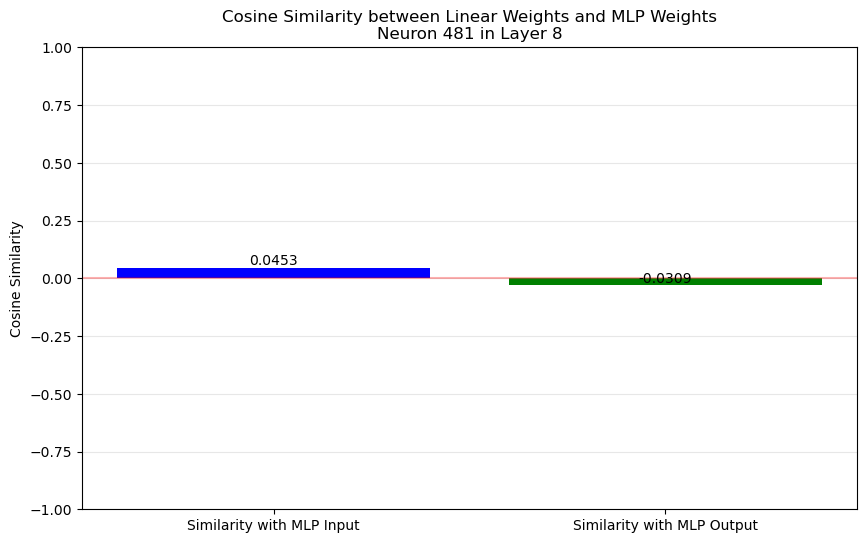

In [75]:
# Create a bar chart comparing similarities
plt.figure(figsize=(10, 6))
bars = plt.bar(['Similarity with MLP Input', 'Similarity with MLP Output'], 
        [sim_with_input.item(), sim_with_output.item()],
        color=['blue', 'green'])

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom')

plt.ylim(-1, 1)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.title(f'Cosine Similarity between Linear Weights and MLP Weights\nNeuron {target_neuron} in Layer {target_layer}')
plt.ylabel('Cosine Similarity')
plt.grid(axis='y', alpha=0.3)
plt.savefig('weight_similarity_comparison.png')
plt.show()

## 5. Analyze Weight Distributions

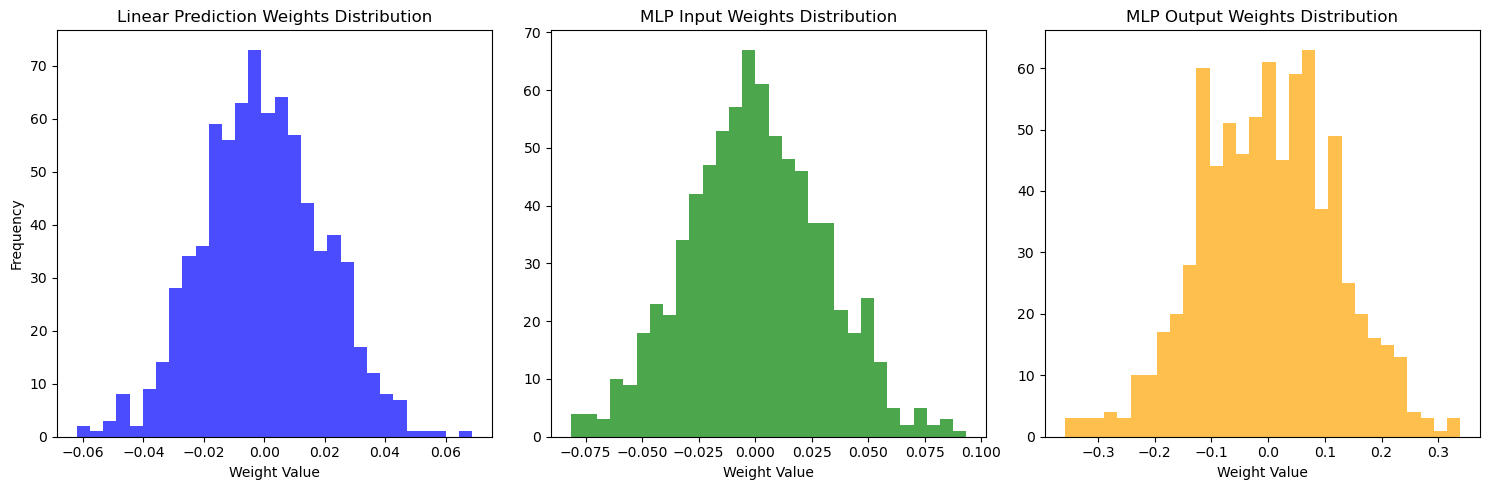

In [76]:
# Analyze weight distributions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(linear_weights.detach().cpu().numpy(), bins=30, alpha=0.7, color='blue')
plt.title('Linear Prediction Weights Distribution')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(neuron_in_weights.detach().cpu().numpy(), bins=30, alpha=0.7, color='green')
plt.title('MLP Input Weights Distribution')
plt.xlabel('Weight Value')

plt.subplot(1, 3, 3)
plt.hist(neuron_out_weights.detach().cpu().numpy(), bins=30, alpha=0.7, color='orange')
plt.title('MLP Output Weights Distribution')
plt.xlabel('Weight Value')

plt.tight_layout()
plt.savefig('weight_distributions.png')
plt.show()

In [77]:
# Compute statistics for each weight vector
def compute_weight_stats(weights, name):
    """Compute basic statistics for weight tensor"""
    w = weights.detach().cpu().numpy()
    return {
        "name": name,
        "mean": float(np.mean(w)),
        "std": float(np.std(w)),
        "min": float(np.min(w)),
        "max": float(np.max(w)),
        "l2_norm": float(np.linalg.norm(w)),
        "sparsity": float(np.mean(np.abs(w) < 1e-5))
    }

# Compute and display statistics
stats = [
    compute_weight_stats(linear_weights, "Linear Prediction Weights"),
    compute_weight_stats(neuron_in_weights, "MLP Input Weights"),
    compute_weight_stats(neuron_out_weights, "MLP Output Weights")
]

print("Weight Statistics:")
for s in stats:
    print(f"\n{s['name']}:")
    for k, v in s.items():
        if k != 'name':
            print(f"  {k}: {v:.6f}")

Weight Statistics:

Linear Prediction Weights:
  mean: -0.000439
  std: 0.019859
  min: -0.062032
  max: 0.068913
  l2_norm: 0.550474
  sparsity: 0.001302

MLP Input Weights:
  mean: 0.000000
  std: 0.030224
  min: -0.081602
  max: 0.093352
  l2_norm: 0.837605
  sparsity: 0.000000

MLP Output Weights:
  mean: 0.000000
  std: 0.119333
  min: -0.358986
  max: 0.338473
  l2_norm: 3.307065
  sparsity: 0.001302


## 6. Visualize with Dimensionality Reduction

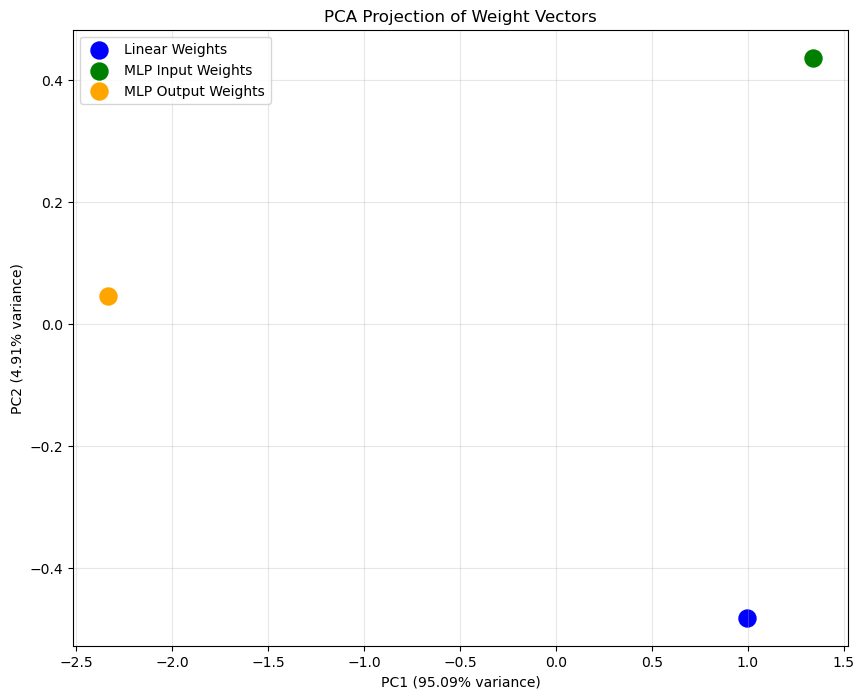

In [78]:
# If the weights are high-dimensional, try visualizing with PCA
from sklearn.decomposition import PCA

# Prepare weight vectors
weight_vectors = [
    ("Linear Weights", linear_weights.detach().cpu().numpy()),
    ("MLP Input Weights", neuron_in_weights.detach().cpu().numpy()),
    ("MLP Output Weights", neuron_out_weights.detach().cpu().numpy())
]

# Stack all vectors for PCA
all_weights = np.vstack([w[1].reshape(1, -1) for w in weight_vectors])

# Perform PCA
pca = PCA(n_components=2)
weights_pca = pca.fit_transform(all_weights)

# Plot in 2D space
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'orange']
for i, (name, _) in enumerate(weight_vectors):
    plt.scatter(weights_pca[i, 0], weights_pca[i, 1], label=name, s=150, color=colors[i])

plt.title('PCA Projection of Weight Vectors')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('weight_vectors_pca.png')
plt.show()

## 7. Compare with Random Projection

In [79]:
# Generate random vectors for comparison
def random_similarity_baseline(vector, num_samples=1000):
    """Compare a vector with random vectors to establish a baseline"""
    vector = vector.flatten().detach().cpu().numpy()
    similarities = []
    
    for _ in range(num_samples):
        # Generate random vector with same dimension
        random_vec = np.random.randn(vector.shape[0])
        # Normalize both vectors
        vec_norm = vector / np.linalg.norm(vector)
        rand_norm = random_vec / np.linalg.norm(random_vec)
        # Compute cosine similarity
        sim = np.dot(vec_norm, rand_norm)
        similarities.append(sim)
    
    return {
        "mean": np.mean(similarities),
        "std": np.std(similarities),
        "p5": np.percentile(similarities, 5),
        "p95": np.percentile(similarities, 95),
        "min": np.min(similarities),
        "max": np.max(similarities)
    }

# Calculate random baselines
random_baseline = random_similarity_baseline(linear_weights)

print("Random similarity baseline:")
for k, v in random_baseline.items():
    print(f"  {k}: {v:.6f}")

# Calculate how many standard deviations our similarities are from random
z_score_input = (sim_with_input - random_baseline["mean"]) / random_baseline["std"]
z_score_output = (sim_with_output - random_baseline["mean"]) / random_baseline["std"]

print(f"\nStatistical significance:")
print(f"  Input similarity z-score: {z_score_input:.2f}")
print(f"  Output similarity z-score: {z_score_output:.2f}")

Random similarity baseline:
  mean: 0.000582
  std: 0.036265
  p5: -0.059929
  p95: 0.057943
  min: -0.121890
  max: 0.132252

Statistical significance:
  Input similarity z-score: 1.23
  Output similarity z-score: -0.87


## 8. Summary and Interpretation

In [80]:
# Create a summary table
summary = {
    "model_path": model_path,
    "head_type": config["head_type"],
    "target_layer": target_layer,
    "target_neuron": target_neuron,
    "sim_with_input": sim_with_input.item(),
    "sim_with_output": sim_with_output.item(),
    "random_baseline_mean": random_baseline["mean"],
    "z_score_input": z_score_input.item(),
    "z_score_output": z_score_output.item(),
    "timestamp": str(np.datetime64('now'))
}

print("Analysis Summary:")
for k, v in summary.items():
    print(f"  {k}: {v}")

# Save results
results_path = os.path.join(model_path, "../../../mech_interp_weights_analysis_results.json")
with open(results_path, "w") as f:
    json.dump(summary, f, indent=2)

print(f"\nResults saved to {results_path}")

Analysis Summary:
  model_path: /Users/egg/Documents/ai-safety/Research Projects/neuron_self_report/code1/important-outputs/unfrozen-last-layers-learn-to-predict-30-epochs/regression-after_target-500-30epochs-neuron_l8_n481--mse29.02-20250422_1259/models/neuron_l8_n481_20250422_120142/best_model
  head_type: regression
  target_layer: 8
  target_neuron: 481
  sim_with_input: 0.045291103422641754
  sim_with_output: -0.03094005584716797
  random_baseline_mean: 0.0005822937702578184
  z_score_input: 1.232842206954956
  z_score_output: -0.8692264556884766
  timestamp: 2025-04-23T21:01:03

Results saved to /Users/egg/Documents/ai-safety/Research Projects/neuron_self_report/code1/important-outputs/unfrozen-last-layers-learn-to-predict-30-epochs/regression-after_target-500-30epochs-neuron_l8_n481--mse29.02-20250422_1259/models/neuron_l8_n481_20250422_120142/best_model/../../../mech_interp_weights_analysis_results.json


## Interpretation

Based on the cosine similarities and weight distributions, we can interpret the results as follows:

1. **Similarity with Input Weights**:
   - A high similarity suggests the prediction model has learned to look at the direction entering the neuron.
   - This would mean that the predictor is duplicating the functionality of that particular neuron but not the stuff before it.
   - Patching the neuron's behavior wouldn't change the prediction.
   - But patching the W_in to that layer should change the prediction.

2. **Similarity with Output Weights**:
   - A high similarity suggests the prediction model has learned to look at what the neuron is putting in the residual stream.
   - In this case patching the neuron's output would change the prediction.

Note that similarity with a random baseline will generally be within +/- 0.07.